In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark



In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
findspark.init()


In [ ]:
!pip install pyspark
!wget -q -O ngrok.zip https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok.zip
!pip install pyngrok

Archive:  ngrok.zip
  inflating: ngrok                   


In [ ]:
!pip install --upgrade pyngrok


In [ ]:
!ngrok config add-authtoken 2pJhfwEQBBsopYY71PO962kWdJ6_7nMrMjDVNMNLDFk3R22kq


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Kill all running ngrok processes
ngrok.kill()

print("ngrok process has been killed.")


ngrok process has been killed.


In [ ]:
import os
from pyspark.sql import SparkSession
from pyngrok import ngrok

# Specify the event log directory within Colab's temporary storage
event_log_dir = "/content/spark-event-log"

# Create the directory if it doesn't exist
os.makedirs(event_log_dir, exist_ok=True)

# Initialize SparkSession with event logging enabled
spark = SparkSession.builder \
    .appName("Hotel Prediction Regression") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "16") \
    .config("spark.driver.memory", "16g") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", event_log_dir) \
    .config("spark.ui.port", "4050") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .getOrCreate()

print(spark.sparkContext.uiWebUrl)

# Expose the Spark Web UI using ngrok
spark_ui_tunnel = ngrok.connect(addr="4050")
print(f"Access the Spark Web UI at: {spark_ui_tunnel.public_url}")

# Verify the Spark context
print("SparkSession created successfully!")


http://b8e00ff2bd53:4050
Access the Spark Web UI at: https://07b2-35-199-9-182.ngrok-free.app
SparkSession created successfully!


In [ ]:
hotel_df = spark.read.csv(
    'hotel_dataset.csv',
    header=True,
    inferSchema=True
)

In [ ]:
hotel_df.printSchema()

# Print Dataframe
hotel_df.show()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [ ]:
# Number of rows
num_rows = hotel_df.count()

# Number of columns
num_columns = len(hotel_df.columns)

# Print dimensions
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 119390
Number of columns: 32


Data Cleaning

In [ ]:
hotel_df.dtypes # Getting the datatypes for each column

[('hotel', 'string'),
 ('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'int'),
 ('arrival_date_month', 'string'),
 ('arrival_date_week_number', 'int'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'string'),
 ('babies', 'int'),
 ('meal', 'string'),
 ('country', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('agent', 'string'),
 ('company', 'string'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('reservation_status_date', 'string')]

In [ ]:
hotel_df.describe().show() # Descriptive analysis for each column


+-------+------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|       hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|pr

In [ ]:
hotel_df.summary().show()#Statistical analysis for each column


+-------+------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|       hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|pr

In [ ]:
from pyspark.sql.functions import col, sum, when

# Count missing values, including standard NULLs, empty strings, and common placeholders
hotel_df.select([
    sum(when(col(c).isNull() | (col(c) == "") | col(c).isin("NA", "NULL", "N/A"), 1).otherwise(0)).alias(c)
    for c in hotel_df.columns
]).show()


+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_reque

In [ ]:
# Replace 'attribute_name' with the column name you want unique values for
unique_values = hotel_df.select("country").distinct().count()

# Show unique values
print(unique_values)


178


Step 1: Dropping Columns

In [ ]:
# Remove multiple columns from dataset
hotel_df = hotel_df.drop("agent", "company")
# Show the DataFrame after removing the column
print(len(hotel_df.columns))

30


Step 2 : Removing Duplicate values

In [ ]:
# Remove duplicates
hotel_df  = hotel_df.dropDuplicates()

# Show the count of DataFrame rows  after removing duplicates
print(hotel_df.count())

87370


Step 3: Removing Inconsistent Rows i.e., Missing values

In [ ]:
# Replace "NA" with null in both 'children' and 'country' columns
hotel_df = hotel_df.withColumn("children",
                             when(col("children") == "NA", None).otherwise(col("children"))) \
                 .withColumn("country",
                             when(col("country") == "NULL", None).otherwise(col("country")))

# Drop rows with null 'children' or 'country'
hotel_df = hotel_df.dropna(subset=["children", "country"])

# Show the count of DataFrame rows  after removing inconsistent rows
print(hotel_df.count())

86914


In [ ]:
from pyspark.sql.functions import col, sum, when

# Count missing values, including standard NULLs, empty strings, and common placeholders
hotel_df.select([
    sum(when(col(c).isNull() | (col(c) == "") | col(c).isin("NA", "NULL", "N/A"), 1).otherwise(0)).alias(c)
    for c in hotel_df.columns
]).show()

+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_requests|reservation_status|reser

Step 4: Combining 2 Columns into 1

In [ ]:
# Creating a new column 'kids' by summing the values of 'babies' and 'children' columns
hotel_df = hotel_df.withColumn("kids", col("babies") + col("children").cast("int"))

# Drop the original columns 'FirstName' and 'LastName'
hotel_df = hotel_df.drop("babies", "children")

# Show the DataFrame with the combined column
hotel_df.show()


+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requests|reservation_status|reservatio

Step 5 : Outlier Detection

In [ ]:
from pyspark.sql import functions as F

# Calculate mean and standard deviation of the column
mean = hotel_df.select(F.mean("adr")).collect()[0][0]
stddev = hotel_df.select(F.stddev("adr")).collect()[0][0]

# Calculate Z-Score and identify outliers
threshold = 3  # Define the threshold for Z-score

hotel_df = hotel_df.withColumn("z_score", (F.col("adr") - mean) / stddev)

# Filter out rows where the Z-score is above the threshold
hotel_df = hotel_df.filter(F.abs(F.col("z_score")) <= threshold)

# Drop the 'z_score' column as it's no longer needed
hotel_df = hotel_df.drop("z_score")

# Show the DataFrame after removing outliers
hotel_df.show()

print(hotel_df.count())


+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requests|reservation_status|reservatio

Step 6 : Adding New Season Column

In [ ]:
# Define a mapping of month names to their corresponding seasons
month_to_season = {
    "January": "Winter", "February": "Winter", "March": "Spring", "April": "Spring", "May": "Spring",
    "June": "Summer", "July": "Summer", "August": "Summer", "September": "Fall", "October": "Fall",
    "November": "Fall", "December": "Winter"
}

# Create a case expression to map month names to seasons
hotel_df = hotel_df.withColumn(
    "season",
    F.when(F.col("arrival_date_month") == "January", "Winter")
     .when(F.col("arrival_date_month") == "February", "Winter")
     .when(F.col("arrival_date_month") == "March", "Spring")
     .when(F.col("arrival_date_month") == "April", "Spring")
     .when(F.col("arrival_date_month") == "May", "Spring")
     .when(F.col("arrival_date_month") == "June", "Summer")
     .when(F.col("arrival_date_month") == "July", "Summer")
     .when(F.col("arrival_date_month") == "August", "Summer")
     .when(F.col("arrival_date_month") == "September", "Fall")
     .when(F.col("arrival_date_month") == "October", "Fall")
     .when(F.col("arrival_date_month") == "November", "Fall")
     .otherwise("Winter")  # For December or any unexpected month name
)

# Show the DataFrame with the new 'season' column
hotel_df.show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requests|reservation_status|res

Step 7 : Feature Engineering

In [ ]:
# Assuming 'reservation_status_date' is in the format "dd/MM/yyyy"
# Split the date string by "/"
hotel_df = hotel_df.withColumn(
    "res_day", F.split(F.col("reservation_status_date"), "/").getItem(0)
).withColumn(
    "res_month", F.split(F.col("reservation_status_date"), "/").getItem(1)
).withColumn(
    "res_year", F.split(F.col("reservation_status_date"), "/").getItem(2)
)

# Replace year '15' with '2015' in the 'year' column
# Replace '16' with '2016' and '17' with '2017' in the 'year' column
hotel_df = hotel_df.withColumn(
    "res_year",
    F.when(F.col("res_year") == "15", "2015")
    .when(F.col("res_year") == "16", "2016")
    .when(F.col("res_year") == "17", "2017")
    .otherwise(F.col("res_year"))
)

# Show the updated DataFrame with the new columns
hotel_df.show()




+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+------+-------+---------+--------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requ

In [ ]:
hotel_df.show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+------+-------+---------+--------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requ

In [ ]:
# Show the updated DataFrame with the new 'Reservation_status_date' column in date format
hotel_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: s

In [ ]:
# List of columns to be removed
columns_to_remove = ["reservation_status_date"]

# Drop the columns from the DataFrame
hotel_df = hotel_df.drop(*columns_to_remove)

# Show the DataFrame after removing the columns
hotel_df.printSchema()


root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: s

In [ ]:
# List of columns to be removed
columns_to_remove = ["country"]

# Drop the columns from the DataFrame
hotel_df = hotel_df.drop(*columns_to_remove)

# Show the DataFrame after removing the columns
hotel_df.printSchema()


root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: string (nullable = true)
 |-- days_in_wa

Data Preprocessing

In [ ]:
hotel_df = hotel_df.withColumn("arrival_date_year", hotel_df["arrival_date_year"].cast("string"))

In [ ]:
hotel_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: string (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: string (nullable = true)
 |-- days_in_wai

Data Preprocessing

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# Step 1: Combine weekend and weeknight stays
df = hotel_df.withColumn("total_stays", col("stays_in_weekend_nights") + col("stays_in_week_nights"))

# Step 2: Define categorical columns and transformations
categorical_columns = ["hotel", "arrival_date_year", "arrival_date_month", "meal",
                       "market_segment", "distribution_channel", "reserved_room_type",
                       "assigned_room_type", "deposit_type", "customer_type", "season"]

# Apply StringIndexer and OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe") for col in categorical_columns]

# Step 3: Define numerical columns
numerical_columns = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month",
                     "total_stays", "adults", "previous_cancellations", "previous_bookings_not_canceled",
                     "booking_changes", "days_in_waiting_list", "required_car_parking_spaces",
                     "total_of_special_requests", "kids"]

# Combine numerical and categorical features
assembler = VectorAssembler(
    inputCols=numerical_columns + [col + "_ohe" for col in categorical_columns],
    outputCol="features"
)

# Step 4: Scale features
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Step 5: Build the preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Step 6: Fit and transform the data
df_preprocessed = preprocessing_pipeline.fit(df).transform(df)

# Step 7: Display transformed data
# Display a few rows with transformed features and target
df_preprocessed.select("scaled_features", "adr").show(5, truncate=False)

# Optional: Display intermediate stages
# Indexed columns
df_preprocessed.select([col + "_index" for col in categorical_columns]).show(5)

# One-hot encoded columns
df_preprocessed.select([col + "_ohe" for col in categorical_columns]).show(5)

# Assembled features
df_preprocessed.select("features").show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|scaled_features                                                                                                                                                                            |adr  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(68,[0,1,2,3,4,10,16,28,31,36,41,50,60,64,65],[0.1316146540027137,0.5192307692307693,0.16666666666666666,0.17543859649122806,0.03636363636363636,0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |91.37|
|(68,[0,1,2,3,4,10,16,26,30,36,40,49,60,62,65],[0.15332428765264586,0.5192307692307693,0.23333333333333334,0.07017543859649122,0.03636363636363636,0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|123.0|
|(68,[0,1,2,3,4,10,1

Feature Selection

In [ ]:
# Calculate correlations for numerical columns only
numerical_data = df_preprocessed.select(numerical_columns + ["adr"])  # Numerical columns + target variable

# Dictionary to store correlations
correlations = {}

# Compute correlation for each numerical feature
for col_name in numerical_columns:
    corr = numerical_data.stat.corr(col_name, "adr")
    correlations[col_name] = corr

# Print correlations
print("\nFeature Correlations with Target (adr):")
for feature, corr in correlations.items():
    print(f"{feature}: {corr:.4f}")

# Filter features with high correlation (e.g., abs(corr) > 0.1)
selected_features_corr = [col for col, corr in correlations.items() if abs(corr) > 0.1]
print(f"\nSelected Features Based on Correlation: {selected_features_corr}")



Feature Correlations with Target (adr):
lead_time: 0.0257
arrival_date_week_number: 0.1000
arrival_date_day_of_month: 0.0193
total_stays: 0.0516
adults: 0.2573
previous_cancellations: -0.0540
previous_bookings_not_canceled: -0.0903
booking_changes: -0.0064
days_in_waiting_list: -0.0367
required_car_parking_spaces: 0.0319
total_of_special_requests: 0.1476
kids: 0.3076

Selected Features Based on Correlation: ['arrival_date_week_number', 'adults', 'total_of_special_requests', 'kids']


Assembling the Final Features

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Define final selected features
selected_features = ['arrival_date_week_number', 'adults', 'total_of_special_requests', 'kids']

# Assemble these features into a single vector
assembler_final = VectorAssembler(
    inputCols=selected_features,
    outputCol="final_features"
)

# Transform the dataset
df_final = assembler_final.transform(df_preprocessed)

# Display the dataset with final features
df_final.select("final_features", "adr").show(5, truncate=False)


+------------------+-----+
|final_features    |adr  |
+------------------+-----+
|[28.0,2.0,2.0,0.0]|91.37|
|[28.0,2.0,1.0,0.0]|123.0|
|[28.0,2.0,1.0,0.0]|73.8 |
|[29.0,2.0,1.0,0.0]|98.02|
|[31.0,2.0,0.0,0.0]|120.6|
+------------------+-----+
only showing top 5 rows



Train-Test Split

In [ ]:
# Train-Test Split
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)

print(f"Training Data Count: {train_df.count()}")
print(f"Testing Data Count: {test_df.count()}")


Training Data Count: 60724
Testing Data Count: 25564


Modelling

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Number of input features
num_features = len(selected_features)

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(featuresCol="final_features", labelCol="adr"),
    "Decision Tree": DecisionTreeRegressor(featuresCol="final_features", labelCol="adr"),
    "Gradient Boosted Trees": GBTRegressor(featuresCol="final_features", labelCol="adr"),
    "Generalized Linear Regression": GeneralizedLinearRegression(featuresCol="final_features", labelCol="adr", family="gaussian", link="identity"),
    "Linear Regression": LinearRegression(featuresCol="final_features", labelCol="adr")
}



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define evaluator
evaluator_rmse = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2")

# Train and evaluate models without hyperparameter tuning
metrics = []

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    trained_model = model.fit(train_df)
    predictions = trained_model.transform(test_df)

    # Evaluate performance
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    # Save metrics
    metrics.append({
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

    # Print metrics
    print(f"{model_name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")



--- Training Random Forest ---
Random Forest Results:
  RMSE: 38.9355
  MAE: 29.5064
  R²: 0.3732

--- Training Decision Tree ---
Decision Tree Results:
  RMSE: 39.1482
  MAE: 29.7791
  R²: 0.3663

--- Training Gradient Boosted Trees ---
Gradient Boosted Trees Results:
  RMSE: 37.3728
  MAE: 28.6220
  R²: 0.4225

--- Training Generalized Linear Regression ---
Generalized Linear Regression Results:
  RMSE: 45.1051
  MAE: 33.9703
  R²: 0.1588

--- Training Linear Regression ---
Linear Regression Results:
  RMSE: 45.1051
  MAE: 33.9703
  R²: 0.1588


In [ ]:
from pyspark.sql.functions import rand, min, max

# Generate random predictions within the range of the target variable
adr_min = test_df.select("adr").agg(min("adr")).collect()[0][0]
adr_max = test_df.select("adr").agg(max("adr")).collect()[0][0]

# Add a random guess column to the test dataset
random_predictions = test_df.withColumn("prediction", rand() * (adr_max - adr_min) + adr_min)

# Evaluate performance of random guessing
rmse_random = evaluator_rmse.evaluate(random_predictions)
mae_random = evaluator_mae.evaluate(random_predictions)
r2_random = evaluator_r2.evaluate(random_predictions)

# Print results for random guessing
print("\n--- Random Guessing Results ---")
print(f"  RMSE: {rmse_random:.4f}")
print(f"  MAE: {mae_random:.4f}")
print(f"  R²: {r2_random:.4f}")



--- Random Guessing Results ---
  RMSE: 97.3611
  MAE: 80.2458
  R²: -2.9196


In [ ]:
import pandas as pd

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
print("\n--- Model Performance Metrics ---")
print(metrics_df)



--- Model Performance Metrics ---
                           Model       RMSE        MAE        R²
0                  Random Forest  38.935520  29.506416  0.373154
1                  Decision Tree  39.148246  29.779106  0.366286
2         Gradient Boosted Trees  37.372843  28.621952  0.422461
3  Generalized Linear Regression  45.105109  33.970267  0.158760
4              Linear Regression  45.105109  33.970267  0.158760


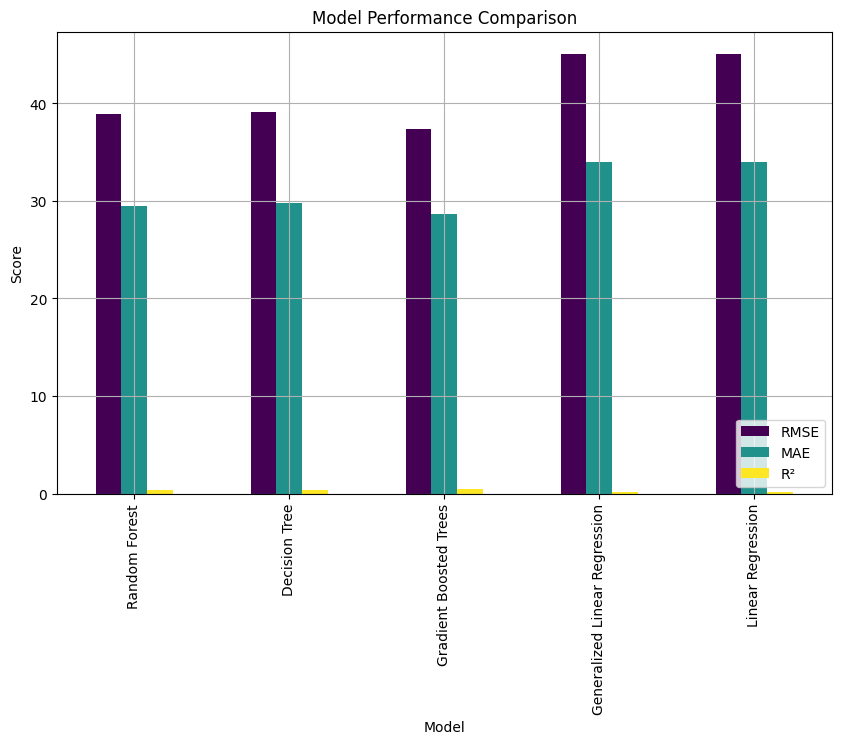

In [ ]:
import matplotlib.pyplot as plt

# Plot metrics as a bar chart
metrics_df.set_index("Model")[["RMSE", "MAE", "R²"]].plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.grid(True)
plt.legend(loc="lower right")
plt.show()


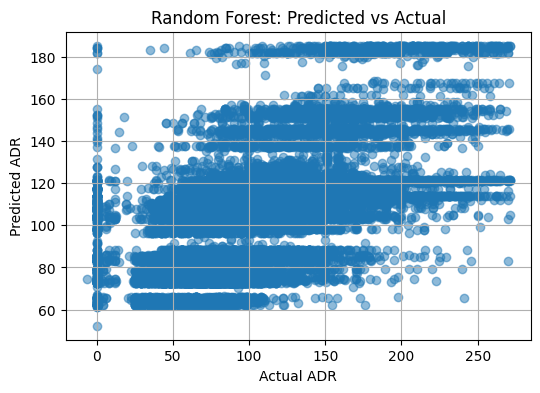

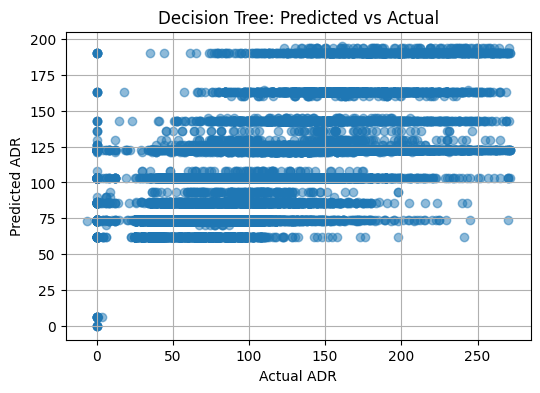

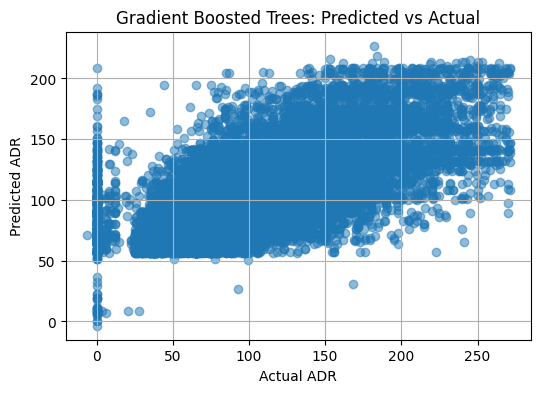

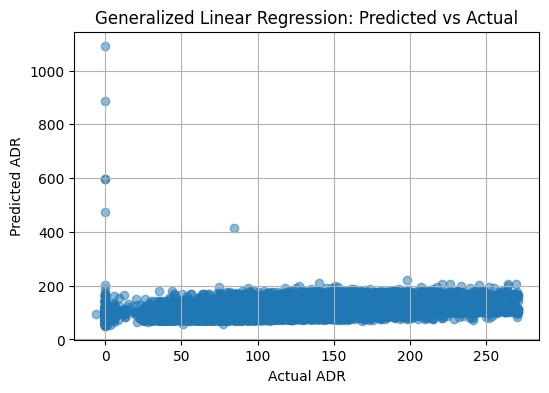

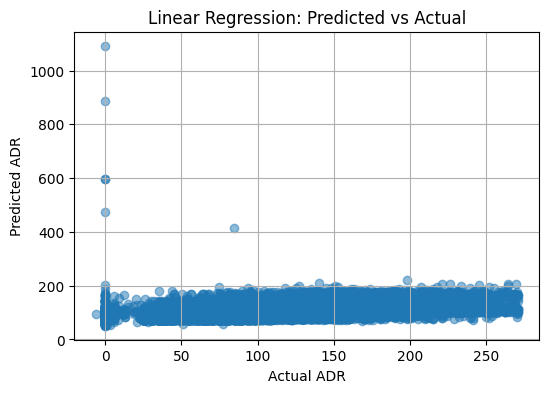

In [ ]:
for model_name, model in models.items():
    predictions = model.fit(train_df).transform(test_df)
    pred_df = predictions.select("adr", "prediction").toPandas()

    # Scatter plot for Predicted vs Actual
    plt.figure(figsize=(6, 4))
    plt.scatter(pred_df["adr"], pred_df["prediction"], alpha=0.5)
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.xlabel("Actual ADR")
    plt.ylabel("Predicted ADR")
    plt.grid(True)
    plt.show()
